In [1]:
import numpy as np
import random
import sympy 
import scipy.stats as st
import scipy.special
import pandas as pd
import csv
import math
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing as mp
import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
from itertools import repeat

from shapely.geometry import LineString

from matplotlib import cm
from numpy import linspace
import itertools

from copy import deepcopy

* 在UORA analytical model module新增的功能
    1. 可以在呼叫module時直接設定OCWmin OCWmax
        * 現有analytical model module是直接在module中寫死
    2. 修正當analytical model module在遇到取頂的目標值為整數時，計算回傳的Imax會有bug
        * ![](https://i.imgur.com/mzRhgrf.png)
        * 例如 R =9 and [Lmax, OCWmin, OCWmax, Imax] = [1,63,63,7]時
            * 理論上正確Imax只需要7就能做完
                * Current UORA analytical model module會計算成Imax要使用到8

In [7]:
## 更新station_number可以正確計算Da
### 前面的實驗我是使用舊的station_number
#### 你如果嫌麻煩的話，可以只宣告這個，然後前面所有實驗ith_slot代0即可
# # k預留封包
# # delta 0 不知道在幹嘛，帶0就是正常
# # TXOP 整個slot時間 (ms)
# # Imax: total slot amount
# # print_able: 要不要print 目前沒用
# # min, max： OCW_min OCW_max
def station_number(sta, RA_RU,Lmax, K, delta,  TXOP, Imax, print_able, min, max, ith_slot=0):

    a_j_i=0
    i=0
    k=0
    n=0
    
    # 計算Da用，上一群在第幾個slot結束
    ith_slot = ith_slot

    c=0
    Nn=0
    j=0
    Nn_index=0
    a=0 
    Sum=0 # "sum" can't be use, replace with "Sum"
    temp=0
    temp1=0
    access_delay=0
    counter_access_delay=0
    success_sta=0
    success_packet=0
    success_probability=0
    total_cdf=0
    Imax = Imax + 1
    retrans =Lmax
    Ri = [0 for _ in range(0,Imax+1)] 
    M  = [0 for _ in range(0,Imax+1)] 
    M_i_s_C = [0 for _ in range(0,Imax+1)] 
    M_i    = [ [0] * (retrans + 1) for _ in range(0, Imax+1)]
    M_i_s  = [ [0] * (retrans + 1) for _ in range(0, Imax+1)]
    M_i_f  = [ [0] * (retrans + 1) for _ in range(0, Imax+1)]
    OCW = [0 for _ in range(0,retrans+1) ]
    
    # setting of OCWmin/max can be moved to the outside of the function
    OCWmin = min
    OCWmax = max
    # setting OCWn
    OCW[1]=OCWmin
    for n in range (2, Lmax+1):
        temp_OCW=2*OCW[n-1]+1
        if temp_OCW<=OCWmax:
            OCW[n]=temp_OCW
        else:
            OCW[n]=OCW[n-1]
    
    for i in range (1,Imax+1): #(i=1;i<=Imax;i++):
        # Ri = Ri-1 - Mi-1,s + Mi-K,s 
        if i==1 :
            Ri[i] = RA_RU
        elif i > 1 and i <= K :
            Ri[i] = Ri[i-1] - M_i_s_C[i-1]
        elif (i >= K+1) :
            Ri[i] = Ri[i-1] - M_i_s_C[i-1] + M_i_s_C[i-K]
        
        #/** Ri for delta */
        if i<= (delta+1) :
            Ri[i] = RA_RU
        elif (i > (delta+1)) and (i < (1+K*(delta+1))) :
            Ri[i] = Ri[i-delta-1] - M_i_s_C[i-delta-1]
        elif (i >= (1 + K*(delta + 1))) :
            Ri[i] = Ri[i-delta-1] - M_i_s_C[i-delta-1] + M_i_s_C[i-K-K*delta]

        for n in range (1, Lmax+1):
            
            #/** initial condition */ 
            if n == 1 :
                if i==1 and Ri[i]>=OCW[n] :
                    a_j_i = 1
                elif i==1 and Ri[i]<OCW[n] :
                    a_j_i = (Ri[i]+1)/(OCW[n]+1) #remove (float)
                elif i>1 :
                    temp = 0
                    for c in range (1,i): #c=1;c<=i-1;c++){
                        temp += Ri[c] #// Sum the Ri
                    if (OCW[n] - temp) >= Ri[i] : #//
                        a_j_i = (Ri[i]/(OCW[n]+1)) #remove (float)
                    elif (OCW[n] - temp) <= 0 :
                        a_j_i = 0 #// 
                    else :
                        a_j_i = (OCW[n]-temp)/(OCW[n]+1) #remove (float)

                M_i[i][n] = a_j_i * sta

            elif n <= i :             #// change to n<=2 ?
                #/** Mi[n]=sigma (a_j_i*Mj,F[n-1]) */ 
                for k in range (1, i) : #(k=1;k<=(i-1);k++){
                    
                    if k == i-1 and Ri[i] < OCW[n] :
                        a_j_i = (Ri[i]+1)/(OCW[n]+1) # remove (float)
                        
                    elif k == i-1 and Ri[i] >= OCW[n] : #//(i==1 && Ri[i]>=OCW[n]){
                        a_j_i = 1
                        
                    elif k < i-1 :
                        temp1 = 0
                        
                        for c in range (k+1, i) : #(c=k+1;c<=i-1;c++){   
                            temp1 += Ri[c]
                            
                        if OCW[n] - temp1 >= Ri[i] :   
                            a_j_i = (Ri[i]/(OCW[n]+1)) # remove (float)
                            
                        elif OCW[n] - temp1 <= 0 :
                            a_j_i = 0
                            
                        else :
                            a_j_i = (OCW[n]-temp1)/(OCW[n]+1) # remove (float)
                            
                    M_i[i][n] += a_j_i * M_i_f[k][n-1]
                    
            M[i] += M_i[i][n]
            
            #/** statistics */  
        for n in range (1,Lmax+1) : # n=1;n<=Lmax;n++){
            if Ri[i] != 0: #avoid Ri=0
                M_i_s[i][n] = M_i[i][n] * math.exp(-M[i]/Ri[i])  # remove (double)
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]       # remove (double)
            M_i_s_C[i] += M_i_s[i][n]


  #/** performance metric */  
  #/** success probability */ 
        success_packet += M_i_s_C[i]*K
        success_sta += M_i_s_C[i]
#         success_probability = success_packet/(sta*K) # remove (double)
        if (i==Imax-1 and print_able==1) :
            success_probability = success_packet/(sta*K) # remove (double)

        counter_access_delay += M_i_s_C[i]* float( K*(i+ith_slot) + ((K-1)*K)/2)
    
        if (i==Imax-1 and print_able==1) :

            access_delay=(TXOP*counter_access_delay)  #/(success_sta*K)# remove (double)
            # 分群的access delay應該要是 (所有群成功的STA*上成功的slot)/所有群成功的STA數
            
    #/** Imax */
    Imax = 0
    for z in range(1,Lmax+1):
        Imax = Imax + math.ceil(OCW[z]/R)
    
    #Throughput 
    through_put= success_packet/Imax

    # sta*success_probability 來算 grouping的Ds
    return Imax,success_probability,access_delay,through_put # ,sta*success_probability

### Step1-2. Func: 找出給定R下所有可能的組合和其Imax
* ![](https://i.imgur.com/v0vIbr9.png)
    * 目的是為了知道給定R、Imax情況下
        * Lmax,OCWmin,OCWmax組合的Ps表現

In [4]:
# input 給定R Lmax_list min_list max_list 算出 Imax list
def all_combination(RA_RU,Lmax_list, min_list, max_list):
    OCWmin =  min_list #[7,15,31,63,127]
    OCWmax =  max_list #[7,15,31,63,127]
    Lmax = Lmax_list #[1,2,3,4,5]
    R = RA_RU
    temp_min = 0
    temp_max = 0
    temp_Lmax = 0
    list = []

    for i in Lmax:
        for x in OCWmin:
            for y in OCWmax:
                OCW = [0 for _ in range(0,i+1) ]
                OCW[1] = x
                for n in range (2, i+1):
                    temp_OCW=2*OCW[n-1]+1
                    if temp_OCW<=y:
                        OCW[n]=temp_OCW
                    else:
                        OCW[n]=OCW[n-1]


                if (not((temp_Lmax == i)&(temp_max == OCW[i])&(temp_min == OCW[1]))):
                    T = 0
                    for z in range(1,i+1):
                        T = T + math.ceil(OCW[z]/R)
                    #print("Lmax: ",i,"\tOCWmin: ",OCW[1],"\tOCWmax: ",OCW[i], "\tT/Imax: ", T)
                    list.append([i,OCW[1],OCW[i],T])
                temp_max = OCW[i]
                temp_min = OCW[1]
                temp_Lmax = i
    list.sort(key = lambda s: s[3])
    return list
# return 

In [5]:
R = 9
list_main = []
list_main = all_combination(R,[1,2,3,4,5], [7,15,31,63,127], [7,15,31,63,127])
print("[Lmax, OCWmin, OCWmax, T/Imax]")
for i in range(len(list_main)):
    print(list_main[i])


[Lmax, OCWmin, OCWmax, T/Imax]
[1, 7, 7, 1]
[1, 15, 15, 2]
[2, 7, 7, 2]
[2, 7, 15, 3]
[3, 7, 7, 3]
[1, 31, 31, 4]
[2, 15, 15, 4]
[4, 7, 7, 4]
[3, 7, 15, 5]
[5, 7, 7, 5]
[2, 15, 31, 6]
[3, 15, 15, 6]
[1, 63, 63, 7]
[3, 7, 31, 7]
[4, 7, 15, 7]
[2, 31, 31, 8]
[4, 15, 15, 8]
[5, 7, 15, 9]
[3, 15, 31, 10]
[5, 15, 15, 10]
[2, 31, 63, 11]
[4, 7, 31, 11]
[3, 31, 31, 12]
[3, 15, 63, 13]
[2, 63, 63, 14]
[4, 7, 63, 14]
[4, 15, 31, 14]
[1, 127, 127, 15]
[5, 7, 31, 15]
[4, 31, 31, 16]
[3, 31, 63, 18]
[5, 15, 31, 18]
[4, 15, 63, 20]
[5, 31, 31, 20]
[3, 63, 63, 21]
[5, 7, 63, 21]
[2, 63, 127, 22]
[4, 31, 63, 25]
[3, 31, 127, 26]
[5, 15, 63, 27]
[4, 15, 127, 28]
[4, 63, 63, 28]
[5, 7, 127, 29]
[2, 127, 127, 30]
[5, 31, 63, 32]
[5, 63, 63, 35]
[3, 63, 127, 37]
[4, 31, 127, 41]
[5, 15, 127, 43]
[3, 127, 127, 45]
[4, 63, 127, 52]
[5, 31, 127, 56]
[4, 127, 127, 60]
[5, 63, 127, 67]
[5, 127, 127, 75]


### Step1-3. Func: 執行分析和跑圖
跑當T/Imax相同但不同(Lmax, OCWmin, OCWmax)組合下的表現圖
* 如果要和Simulation比對，執行1-3前記得讀取simulaion CSV
* Simulation的data你想怎麼讀取都可以，我這裡的做法是
    * 同一個CSV裡放相同R、Imax(T)的所有組合從(M=10~200)的表現
* 可以看範例檔
    * https://drive.google.com/file/d/1uKlJ-UTN2KqUyXVevgBEd6JlaJLQ4zcb/view?usp=sharing

```python=
# Read simulation data
simple_test = pd.read_csv('simpletest_c_sim_k2.csv')
sim_1 = simple_test
```

In [6]:
# Read simulation data
simple_test = pd.read_csv('simpletest_c_sim_k2.csv')
sim_1 = simple_test

FileNotFoundError: [Errno 2] No such file or directory: 'simpletest_c_sim_k2.csv'

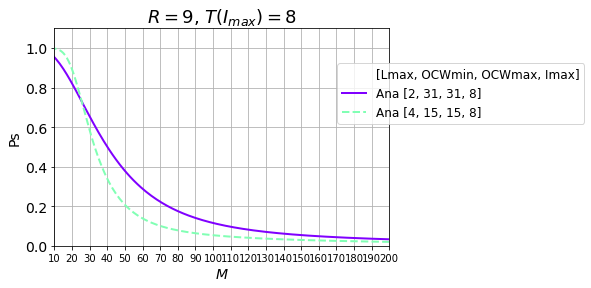

In [6]:
# 檢查所有的組合在給定條件下(R,T,M)的表現 (可以一次觀測所有T下不同組合的表現)

# color=iter(cm.rainbow(np.linspace(0,1,len(T_1)+1)))
line=iter(  ['-','--','-.',':']*30)
mark =iter( ['o','^','*','v','s','p','h','<','>','s','p','h','x']*30)


for T in range(list_main[0][3],list_main[-1][3]+1):
    x=0 
    y=0

    for i in range(len(list_main)):
        if list_main[i][3] == T:
            x= x+1
        else:
            continue

    Ps_list = [[] for i in repeat(None, x)]

    for i in range(len(list_main)):
        if list_main[i][3] == T:
            Ps_list[y].append(list_main[i])
            y = y+1
        else:
            continue
            
#     if (len(Ps_list)>0):
#         print(Ps_list)    


    M_ticks = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
    # 每個點都取樣    
    M = [i for i in range(1,201)]

    for i in range(len(Ps_list)):
        for n in range(len(M)):
            the_Imax = 0
            the_Ps=0
            the_Da=0
            the_Tp=0
            the_Imax,the_Ps,the_Da,the_Tp = station_number( M[n], R, Ps_list[i][0][0], 1, 0, 5.681,Ps_list[i][0][3],1,Ps_list[i][0][1],Ps_list[i][0][2], 0)
#             print("Ps: ", the_Ps,"\t Da: ", the_Da,"\t Imax: ", the_Imax)
            Ps_list[i].append(the_Ps)

    ## 加 and T == 8條件式就會只觀看T/Imax==8的表現
    if (len(Ps_list)>0 and T == 8):  ## 加 and T == 8條件式就會只觀看T/Imax==8的表現
        plt.plot(M,Ps_list[0][1:], '-',alpha = 0,color = 'purple',label = "[Lmax, OCWmin, OCWmax, Imax]")
        
        color=iter(cm.rainbow(np.linspace(0,1,len(Ps_list)+1)))
        for i in range(len(Ps_list)):
#             plt.plot(M,Ps_list[i][1:], '-',label = "Ana "+ str(Ps_list[i][0]))

            c=next(color)
            l = next(line)
            plt.plot(M,Ps_list[i][1:], '-', color =c,linestyle = l, linewidth = 2,label = "Ana "+ str(Ps_list[i][0]))
#             plt.plot(M_1,averaged_Ps[i][1], '-', color =c,linestyle = l, linewidth = 2,label = "Ana "+', Total  $Ps$' +', when $T2 = $' +str(G2_Ps[i][0])+', $T1 = $'+ str(T1) )            
            
#         # Compare with simulation # 有simulation Data可以放在這裡比對
#         m =next(mark)
#         # 0:20 -> 10~200台
#         plt.plot(sim_1.M[0:20],sim_1.Ps[0:20], '*',color = 'black',markersize=6,marker = m,label = 'sim ['+str(sim_1.Lmax[0])+", "+str(sim_1.OCWmin[0])+", "+str(sim_1.OCWmax[0])+", "+str(sim_1.Imax[0])+"]")
#         m =next(mark) 
#         plt.plot(sim_1.M[20:40],sim_1.Ps[20:40], '*',color = 'black',markersize=6,marker = m,label = 'sim ['+str(sim_1.Lmax[20])+", "+str(sim_1.OCWmin[20])+", "+str(sim_1.OCWmax[20])+", "+str(sim_1.Imax[20])+"]")
#         m =next(mark) 
#         plt.plot(sim_1.M[40:60],sim_1.Ps[40:60], '*',color = 'black',markersize=6,marker = m,label = 'sim ['+str(sim_1.Lmax[40])+", "+str(sim_1.OCWmin[40])+", "+str(sim_1.OCWmax[40])+", "+str(sim_1.Imax[45])+"]")
#         m =next(mark) 
#         plt.plot(sim_1.M[60:80],sim_1.Ps[60:80], '*',color = 'black',markersize=6,marker = m,label = 'sim ['+str(sim_1.Lmax[60])+", "+str(sim_1.OCWmin[60])+", "+str(sim_1.OCWmax[60])+", "+str(sim_1.Imax[61])+"]")
#         m =next(mark) 
#         plt.plot(sim_1.M[80:100],sim_1.Ps[80:100], '*',color = 'black',markersize=6,marker = m,label = 'sim ['+str(sim_1.Lmax[80])+", "+str(sim_1.OCWmin[80])+", "+str(sim_1.OCWmax[80])+", "+str(sim_1.Imax[81])+"]")


        
               
        
        plt.title('$R = $' + str(R) +', $T(I_{max}) = $' + str(T) , fontsize = 18)
        plt.xlabel("$M$", fontsize = 14)
        plt.ylabel("Ps", fontsize = 14)
        plt.grid(True, which="both")
        plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.7), fontsize = 12)
        plt.axis([10,200,0,1.1]) #x spacing,x max, y spcaing, y max
        plt.rcParams["figure.figsize"] = (8,6)
        plt.xticks(M_ticks)
        plt.yticks(fontsize = 14)
        plt.show()

* Step1學習到的現象
---
1. STA數量越少，(Lmax越高 && OCWmax越小)的組合會有較好Ps表現
    * STA少的時候碰撞機率越小，利用小的OCW就可以錯開碰撞，也因為在給定T下可以有較多次重傳的機會，因此可以有較高成功率
2. STA數量越多，(Lmax越小 && OCWmax越大)的組合會有較好Ps表現
    * STA多的時候碰撞機率越大，所以需要利用大的OCW來錯開碰撞，但是擴大OCW的同時會造成在給定T下只能容納較少重傳的機會，因此可以發現即使(Lmax越小 && OCWmax越大)在STA多的時候相較其他組合有較高成功率，但依然會遠低於當STA少時的成功機率
3. 當OCWmin OCWmax設定導致$OCW_n$都小於R
    * 原因: $OCW_n$都小於R會造成$M_{i}[n]$計算結果都相同
4. 關於交叉點/區，R越小 && Imax越小對於STA數量多寡的定義會是在較小的$M$以上為多、以下為少
5. 並非所有Imax都可以在給定R下透過調整(Lmax, OCWmin, OCWmax)組出來


### Step 2
* Step2 要實現的func
    1. 過濾(Lmax, OCWmin, OCWmax)組合、最多只留下2種組合((Lmax最高 && OCWmax最小)和(Lmax最小 && OCWmax最大))方便第4步直接判斷 <br>**(給定Mj 找最佳配置)**
    2. 紀錄所有R、Imax的交叉點方便第4步可以直接判斷
    3. 根據給定的T、總Imax範圍和R，先過濾並留下符合的$\sum_{j=1}^{j=2} T_j$組合
    4. 給定R、$T_j$、$M_j$後判斷該使用哪組(Lmax, OCWmin, OCWmax)
    5. performance always比別人低的就可以放掉
        * 那些組合是必要那些可以捨棄的，才能讓我的圖可讀性變高

In [8]:
# 給定R來看有哪些組合(只留下極端組合 (Lmax最高 && OCWmax最小)和(Lmax最小 && OCWmax最大))
R = 9
list_main = []
list_main = all_combination(R,[1,2,3,4,5], [7,15,31,63,127], [7,15,31,63,127])
list1 = []



# 挑出有3組以上(Lmax, OCWmin, OCWmax)組合的T/Imax
data = np.array(list_main)
x = 1
for x in range(1,100):      
    data1= np.array(np.where(data[:,3] == x)).flatten()
    if data1.size>=3:
        list1.append(data1.tolist())
#print(list1)


# 留下(Lmax最高 && OCWmax最小)
temp_maxLmax = 1
temp_minOCWmax = 127
temp_nmax = 0
list2 = []
for i in range(len(list1)):
    for n in list1[i]:
        if list_main[n][0] >= temp_maxLmax and list_main[n][2] <= temp_minOCWmax:
            temp_maxLmax = list_main[n][0]
            temp_minOCWmax = list_main[n][2]
            temp_nmax = n
        else:
            continue
    list2.append(temp_nmax)
    temp_maxLmax = 1
    temp_minOCWmax = 127
    temp_nmax = 0
# print(list2)

# 留下(Lmax最小 && OCWmax最大)
temp_minLmax = 5
temp_maxOCWmax = 7
temp_nmin = 0
list3 = []
for i in range(len(list1)):
    for n in list1[i]:
        if list_main[n][0] <= temp_minLmax and list_main[n][2] >= temp_maxOCWmax:
            temp_minLmax = list_main[n][0]
            temp_maxOCWmax = list_main[n][2]
            temp_nmin = n
        else:
            continue
    list3.append(temp_nmin)
    temp_minLmax = 5
    temp_maxOCWmax = 7
    temp_nmin = 0
# print(list3)


# 更新list，3組以上的只留下極端組合，每種R Imax只會剩下1或2組
list1 = [b for a in list1 for b in a]
for i in range(len(list2)):
    list1.remove(list2[i])
for i in range(len(list3)):
    list1.remove(list3[i]) 
# print(list1)
list_main = [list_main[i] for i in range(len(list_main)) if i not in list1]

# 刪除例外狀況: 過濾成兩組以下後有相同Ps表現的需合併成一組(把Lmax相同且OCWn都小於R導致結果都相同的組合只留一個)
if list_main[0][0] == list_main[1][0] ==1 and list_main[0][2] < R and list_main[1][2] < R:
    list_main.pop(0)

print("[Lmax, OCWmin, OCWmax, Imax]")
for i in range(len(list_main)):
    print(list_main[i])  

[Lmax, OCWmin, OCWmax, Imax]
[1, 7, 7, 1]
[1, 15, 15, 2]
[2, 7, 7, 2]
[2, 7, 15, 3]
[3, 7, 7, 3]
[1, 31, 31, 4]
[4, 7, 7, 4]
[3, 7, 15, 5]
[5, 7, 7, 5]
[2, 15, 31, 6]
[3, 15, 15, 6]
[1, 63, 63, 7]
[4, 7, 15, 7]
[2, 31, 31, 8]
[4, 15, 15, 8]
[5, 7, 15, 9]
[3, 15, 31, 10]
[5, 15, 15, 10]
[2, 31, 63, 11]
[4, 7, 31, 11]
[3, 31, 31, 12]
[3, 15, 63, 13]
[2, 63, 63, 14]
[4, 15, 31, 14]
[1, 127, 127, 15]
[5, 7, 31, 15]
[4, 31, 31, 16]
[3, 31, 63, 18]
[5, 15, 31, 18]
[4, 15, 63, 20]
[5, 31, 31, 20]
[3, 63, 63, 21]
[5, 7, 63, 21]
[2, 63, 127, 22]
[4, 31, 63, 25]
[3, 31, 127, 26]
[5, 15, 63, 27]
[4, 15, 127, 28]
[4, 63, 63, 28]
[5, 7, 127, 29]
[2, 127, 127, 30]
[5, 31, 63, 32]
[5, 63, 63, 35]
[3, 63, 127, 37]
[4, 31, 127, 41]
[5, 15, 127, 43]
[3, 127, 127, 45]
[4, 63, 127, 52]
[5, 31, 127, 56]
[4, 127, 127, 60]
[5, 63, 127, 67]
[5, 127, 127, 75]


### Step2-2. 紀錄過濾(Lmax, OCWmin, OCWmax)組合後所有R、Imax的交叉點
找出所有R、Imax的M交叉點

In [9]:
# Record all fixed R and Imax下的交叉點
list4 = []

for T in range(list_main[0][3],list_main[-1][3]+1):
    x=0 
    y=0

    for i in range(len(list_main)):
        if list_main[i][3] == T:
            x= x+1
        else:
            continue

    Ps_list = [[] for i in repeat(None, x)]

    for i in range(len(list_main)):
        if list_main[i][3] == T:
            Ps_list[y].append(list_main[i])
            y = y+1
        else:
            continue

#     M = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
    M = [i for i in range(1,201)]

    for i in range(len(Ps_list)):
        for n in range(len(M)):
            the_Imax = 0
            the_Ps=0
            the_Da=0
            the_Tp=0
            the_Imax,the_Ps,the_Da,the_Tp = station_number( M[n], R, Ps_list[i][0][0], 1, 0, 5.673,Ps_list[i][0][3],1,Ps_list[i][0][1],Ps_list[i][0][2])
            Ps_list[i].append(the_Ps)

# 找有2組的R Imax其交叉點
            
    if (len(Ps_list)>1):

#         for i in range(len(Ps_list)):
#             plt.plot(M,Ps_list[i][1:], '-',label = "Ana "+ str(Ps_list[i][0]))

        first_line = LineString(np.column_stack((M, Ps_list[0][1:])))
        second_line = LineString(np.column_stack((M, Ps_list[1][1:])))
        intersection = first_line.intersection(second_line)
        if intersection.geom_type == 'MultiPoint':
            # 處理例外狀況，理論上都只會形成一個交叉點，在R=36 Imax=9會因python計算導致有兩個交點(手動去除錯誤的交叉點)
            x, y = LineString(intersection).xy
            list5 = []
            list5.append(x.tolist())
            list5 = [b for a in list5 for b in a]
            list5.pop(0)
            list4.append(list5)
        elif intersection.geom_type == 'Point':
            x, y = intersection.xy
            list4.append(x.tolist())


list4 = [b for a in list4 for b in a]

print(list4)

<ipython-input-9-00f6386bc260>:47: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  x, y = LineString(intersection).xy
/Users/erictsai/opt/anaconda3/lib/python3.8/site-packages/shapely/geometry/linestring.py:46: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ret = geos_linestring_from_py(coordinates)


[13.840870593470871, 16.48357047254622, 19.37297762643073, 21.070149810320647, 23.862275012347233, 24.606629910115814, 25.42204623505548, 28.519861099412466, 26.644021545875383, 29.40102649620413, 38.46553602772405, 33.80482378640286, 42.16986532055753, 26.88188409654578, 5.05930251978647]


In [10]:
# Record all fixed R and Imax's intersection into list

print("[Lmax, OCWmin, OCWmax, Imax, intersection]")
buffer = 0       
x = 0
for i in range(len(list_main)):
    if list_main[i][3] == buffer and len(list4)!=0:
        list_main[i].append(list4[x])
        x = x+1
        buffer = list_main[i][3]
    else:
        buffer = list_main[i][3]
        list_main[i].append(0)
for i in range(len(list_main)):
    print(list_main[i])

[Lmax, OCWmin, OCWmax, Imax, intersection]
[1, 7, 7, 1, 0]
[1, 15, 15, 2, 0]
[2, 7, 7, 2, 13.840870593470871]
[2, 7, 15, 3, 0]
[3, 7, 7, 3, 16.48357047254622]
[1, 31, 31, 4, 0]
[4, 7, 7, 4, 19.37297762643073]
[3, 7, 15, 5, 0]
[5, 7, 7, 5, 21.070149810320647]
[2, 15, 31, 6, 0]
[3, 15, 15, 6, 23.862275012347233]
[1, 63, 63, 7, 0]
[4, 7, 15, 7, 24.606629910115814]
[2, 31, 31, 8, 0]
[4, 15, 15, 8, 25.42204623505548]
[5, 7, 15, 9, 0]
[3, 15, 31, 10, 0]
[5, 15, 15, 10, 28.519861099412466]
[2, 31, 63, 11, 0]
[4, 7, 31, 11, 26.644021545875383]
[3, 31, 31, 12, 0]
[3, 15, 63, 13, 0]
[2, 63, 63, 14, 0]
[4, 15, 31, 14, 29.40102649620413]
[1, 127, 127, 15, 0]
[5, 7, 31, 15, 38.46553602772405]
[4, 31, 31, 16, 0]
[3, 31, 63, 18, 0]
[5, 15, 31, 18, 33.80482378640286]
[4, 15, 63, 20, 0]
[5, 31, 31, 20, 42.16986532055753]
[3, 63, 63, 21, 0]
[5, 7, 63, 21, 26.88188409654578]
[2, 63, 127, 22, 0]
[4, 31, 63, 25, 0]
[3, 31, 127, 26, 0]
[5, 15, 63, 27, 0]
[4, 15, 127, 28, 0]
[4, 63, 63, 28, 5.05930251978647]

### Step2-3. 根據給定的T、總Imax範圍和R，先過濾符合的$\sum_{j=0}^{j=1} T_j$組合

#### 方案1. 過濾只留下使用相同T2，T1不同的組合

In [11]:
# 單看Tj相同，另一群Tj要使用哪種會有較好表現的情況
## 過濾: 證明找到最佳Tj 另一群Tj應該用越大越好或是和最佳Tj相同

Tj = 15
# 設立觀察時間: T (unit: slot)
T = 20

# 根據觀察時間給定可接受的總Imax範圍
Imax_min = T
Imax_max = int(1.1*T)

print(type(Imax_min,Imax_max+1))

print(range(Imax_min,Imax_max+1))
print(range(20,23))

Imax = list(range(Imax_min,Imax_max+1))
print("Total afforded Imax: ",Imax)

# 給定T_1時間(未過濾)
T_1 = list(range(1,T))
# T_1不可以剛好等於T 2022/6/21
# T_1 = list(range(1,Imax_max))

# print("T_1:", T_1)

# 設立T_2時間(未過濾)
T_2_buffer = []
for i in range(len(T_1)):
    temp = (np.array(Imax)-T_1[i]).tolist()
    T_2_buffer.append([T_1[i],temp])
print("Unfliter T_1 with T_2", T_2_buffer)

# 過濾留下給定R下組合得出來的Imax

## 先過濾不符合的T_1 & 刪除該T_1對應的T_2
list_compare = [list_main[i][3] for i in range(len(list_main))]
# T_1 = [l for l in list_compare if l in T_1]
### 額外過濾T1 = 1 or 2狀況
T_1 = [l for l in list_compare if l in T_1 if l !=1 if l !=2]
T_1 = (np.unique(np.array(T_1))).tolist()
print("Filted T_1: ", T_1)

T_2 = []
for i in range(len(T_2_buffer)):
    if T_2_buffer[i][0] in T_1:
        T_2.append(T_2_buffer[i][1])
    else:
        continue


## 過濾剩餘符合的T_1中不符合的T_2
for i in range(len(T_2)):
    T_2[i]=[l for l in list_compare if l in T_2[i]]
    T_2[i]= (np.unique(np.array(T_2[i]))).tolist()
print("Filted T_2: ", T_2)

### 先合併T1 T2 list好處理剩餘狀況 
T_1_2 = []
for i in range(len(T_2)):
    T_1_2.append([T_1[i],T_2[i]])
print("Filted T_1_2: ", T_1_2)

T_1 = []
T_2 = []
for i in range(len(T_1_2)):
    for k in range(len(T_1_2[i][1])):
        if T_1_2[i][1][k] == Tj:
            T_1.append(T_1_2[i][0])
            T_2.append([T_1_2[i][1][k]])

print("new Filted T_1: ", T_1)    
print("new Filted T_2: ", T_2)

color_count = [b for a in T_2 for b in a]
print(len(color_count))

TypeError: type() takes 1 or 3 arguments